In [70]:
import pandas as pd 
import numpy as np
import re
import random
import math
from bs4 import BeautifulSoup

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model

import bert

In [71]:
spamTexts = pd.read_csv('spam.csv', engine='python')
print(spamTexts.shape)

(5572, 5)


In [4]:
spamTexts.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


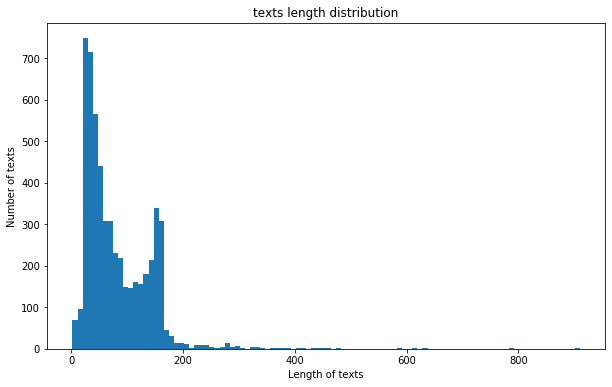

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(spamTexts['v2'])], 100)
plt.xlabel('Length of texts')
plt.ylabel('Number of texts')
plt.title('texts length distribution')
plt.show()

In [6]:
print("len of shotest text : ", len(min(spamTexts['v2'], key=len)))
print("len of longest text : ", len(max(spamTexts['v2'], key=len)))

len of shotest text :  2
len of longest text :  910


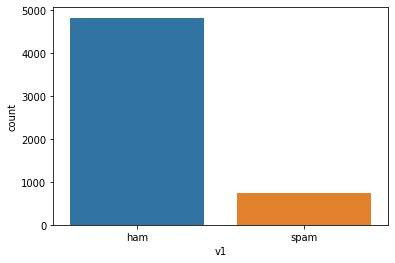

In [72]:
import seaborn as sns
sns.countplot(x='v1',data=spamTexts)

In [7]:
def denoise_text(text):    
    # Remove the html strips
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    # Remove digits and punctuations 
    pattern=r'[^a-zA-Z]'
    text=re.sub(pattern,' ',text)
    
    # Remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
        
    return text

In [8]:
clean_texts = []
sentences = list(spamTexts['v2'])
for sen in sentences:
    clean_texts.append(denoise_text(sen))

In [9]:
clean_texts[0]

'Go until jurong point crazy Available only in bugis great world la buffet Cine there got amore wat '

In [10]:
spamTexts['v2'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [11]:
print(spamTexts.columns.values)
spamTexts.v1.unique()

['v1' 'v2' 'Unnamed: 2' 'Unnamed: 3' 'Unnamed: 4']


array(['ham', 'spam'], dtype=object)

In [12]:
y = spamTexts['v1']

y = np.array(list(map(lambda x: 1 if x=="spam" else 0, y)))

In [13]:
print(clean_texts[10])
print(y[10])

I gonna be home soon and don want to talk about this stuff anymore tonight I ve cried enough today 
0


In [14]:
clean_texts_with_y = [[txt, y[i]] for i, txt in enumerate(clean_texts)]

In [15]:
random.shuffle(clean_texts_with_y)

In [16]:
clean_texts_with_y[0][0]

'Doc prescribed me morphine cause the other pain meds aren enough Waiting for my mom to bring it That med should kick in fast so m gonna try to be on later'

In [17]:
train_X ,train_Y, test_X, test_Y = [], [], [], []

train_size = math.ceil(len(clean_texts_with_y)*0.8)

for e in clean_texts_with_y[:train_size]:
    train_X.append(e[0])
    train_Y.append(e[1])

for e in clean_texts_with_y[train_size:]:
    test_X.append(e[0])
    test_Y.append(e[1])
    
print("train_size:",len(train_X))
print("test_size:",len(test_X))

train_size: 4458
test_size: 1114


In [18]:
#bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
bert_layer = hub.KerasLayer("F:\\Projects\\bertmodel", trainable=False)

In [19]:
BertTokenizer=bert.bert_tokenization.FullTokenizer
 
vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
 
tokenizer=BertTokenizer(vocab_file,do_lower_case)

In [20]:
print(tokenizer.tokenize("I don't like this movie"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I don't like this movie")))

['I', 'don', "'", 't', 'like', 'this', 'movie']
[146, 1274, 112, 189, 1176, 1142, 2523]


In [21]:
def get_ids_masks_segs(tokens, tokenizer, max_seq_length):
    
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
            
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    if len(token_ids) < max_seq_length:
        input_ids = token_ids + [0] * (max_seq_length - len(token_ids))
        masks = [1]*len(tokens) + [0] * (max_seq_length - len(tokens))
        segments = segments + [0] * (max_seq_length - len(tokens))
    else:
        input_ids = token_ids[:max_seq_length]
        masks = [1] * max_seq_length
        segments = segments[:max_seq_length]
    
    return input_ids, masks, segments

In [22]:
from tqdm import tqdm
MAX_SEQ_LEN = 128
def create_input_array(sentences):
    
    input_ids, input_masks, input_segments = [], [], []

    for sentence in sentences: # tqdm(sentences, position=0, leave=True):
        tokens = tokenizer.tokenize(sentence)  
        tokens = tokens[:MAX_SEQ_LEN-2]
  
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        ids, masks, segments = get_ids_masks_segs(tokens, tokenizer, MAX_SEQ_LEN)        

        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [23]:
inputs = create_input_array(train_X)

In [24]:
print(inputs[0].shape)
print(inputs[1].shape)
print(inputs[2].shape)

print(inputs[0][10])
print(inputs[1][10])
print(inputs[2][10])

(4458, 128)
(4458, 128)
(4458, 128)
[  101  2185  1122  9979  1209  1294  1128  7015  1114  4687  1821  1280
  1106 15933  1240  3919  1114  1139 14458   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [25]:
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")

In [26]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [27]:
print(sequence_output.shape)
print(pooled_output.shape)

(None, None, 1024)
(None, 1024)


In [28]:
hidden_units = 1024
learning_rate = 0.0002

x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(units=hidden_units, activation='sigmoid')(x)
x = tf.keras.layers.Dense(units=hidden_units, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
out = tf.keras.layers.Dense(units=1, activation="sigmoid", name="dense_output")(x)
 
model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

model.compile(loss="binary_crossentropy", optimizer=Adam(lr=learning_rate), metrics=["accuracy"])


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 333579265   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [30]:
model_name="model_spam_bert_classifier.hdf5" 
#checkpointer = ModelCheckpoint(model_name, monitor='loss', save_best_only=True, mode='min')
checkpointer = ModelCheckpoint(model_name, monitor='loss')
history = model.fit(inputs, np.array(train_Y), epochs=10, batch_size=32, 
                    validation_split=0.2, shuffle=True, callbacks=[checkpointer])

Train on 3566 samples, validate on 892 samples
Epoch 1/10
3566/3566 [==============================] - 467s 131ms/sample - loss: 1.0050 - accuracy: 0.9551 - val_loss: 0.8149 - val_accuracy: 0.9798
Epoch 2/10
3566/3566 [==============================] - 410s 115ms/sample - loss: 0.6738 - accuracy: 0.9849 - val_loss: 0.5870 - val_accuracy: 0.9809
Epoch 3/10
3566/3566 [==============================] - 414s 116ms/sample - loss: 0.4824 - accuracy: 0.9896 - val_loss: 0.4410 - val_accuracy: 0.9809
Epoch 4/10
3566/3566 [==============================] - 409s 115ms/sample - loss: 0.3570 - accuracy: 0.9907 - val_loss: 0.3352 - val_accuracy: 0.9821
Epoch 5/10
3566/3566 [==============================] - 408s 114ms/sample - loss: 0.2719 - accuracy: 0.9913 - val_loss: 0.2689 - val_accuracy: 0.9843
Epoch 6/10
3566/3566 [==============================] - 437s 122ms/sample - loss: 0.2100 - accuracy: 0.9924 - val_loss: 0.2244 - val_accuracy: 0.9798
Epoch 7/10
3566/3566 [==============================]

In [31]:
history.history['loss']

[1.0049755920604315,
 0.6738352671273959,
 0.4823774124422036,
 0.35702650238139805,
 0.27191160187183705,
 0.21003410303719713,
 0.1675755740031057,
 0.13620186835711282,
 0.11262808663251356,
 0.09589453962115979]

In [32]:
trfile = open('spam_bert_train_10.csv', "ab")    
np.savetxt(trfile, history.history['loss'], fmt="%2.6f",delimiter=",")
trfile.close()

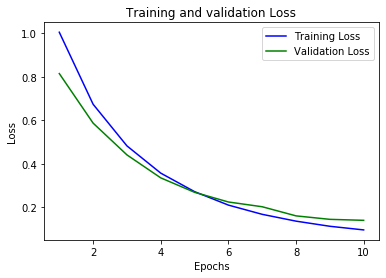

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

#acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [61]:
test_inputs=create_input_array(test_X)

In [62]:
results = model.predict(test_inputs)

In [63]:
pred_Y=[]
for i in range(len(results)):
    if results[i] >= 0.5:
        pred_Y.append(1)
    else:
        pred_Y.append(0)      

In [65]:
res = []
for i in range(len(test_Y)):
    res.append([test_Y[i],pred_Y[i]])


In [38]:
trfile = open('spam_bert_test_10.csv', "ab")    
np.savetxt(trfile, res, fmt="%2.6f",delimiter=",")
trfile.close()

In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
fpr, tpr, thresholds = roc_curve(test_Y, pred_Y)
auc(fpr, tpr)

0.9150540499665113

In [41]:

print("precision : ", precision_score(test_Y, pred_Y, average="micro"))
print("recall : ", recall_score(test_Y, pred_Y, average="micro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="micro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))
#print(confusion_matrix(test_Y, pred_Y))

precision :  0.9766606822262118
recall :  0.9766606822262118
f1_score :  0.9766606822262118
accuracy_score :  0.9766606822262118


In [42]:
print("precision : ", precision_score(test_Y, pred_Y, average="macro"))
print("recall : ", recall_score(test_Y, pred_Y, average="macro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="macro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))

precision :  0.9796509450450676
recall :  0.9150540499665114
f1_score :  0.9441384311547245
accuracy_score :  0.9766606822262118


In [61]:
#for i in range(len(pred_Y)):
#    print(test_Y[i], pred_Y[i])

In [43]:
model_name="model_spam_bert_classifier.hdf5" 
#checkpointer = ModelCheckpoint(model_name, monitor='loss', save_best_only=True, mode='min')
checkpointer = ModelCheckpoint(model_name, monitor='loss')
history = model.fit(inputs, np.array(train_Y), epochs=10, batch_size=32, 
                    validation_split=0.2, shuffle=True, callbacks=[checkpointer])

Train on 3566 samples, validate on 892 samples
Epoch 1/10
3566/3566 [==============================] - 103s 29ms/sample - loss: 0.0799 - accuracy: 0.9950 - val_loss: 0.1154 - val_accuracy: 0.9809
Epoch 2/10
3566/3566 [==============================] - 100s 28ms/sample - loss: 0.0725 - accuracy: 0.9944 - val_loss: 0.1119 - val_accuracy: 0.9865
Epoch 3/10
3566/3566 [==============================] - 100s 28ms/sample - loss: 0.0605 - accuracy: 0.9961 - val_loss: 0.1192 - val_accuracy: 0.9821
Epoch 4/10
3566/3566 [==============================] - 105s 29ms/sample - loss: 0.0619 - accuracy: 0.9916 - val_loss: 0.1048 - val_accuracy: 0.9843
Epoch 5/10
3566/3566 [==============================] - 104s 29ms/sample - loss: 0.0504 - accuracy: 0.9964 - val_loss: 0.0983 - val_accuracy: 0.9832
Epoch 6/10
3566/3566 [==============================] - 100s 28ms/sample - loss: 0.0448 - accuracy: 0.9964 - val_loss: 0.0891 - val_accuracy: 0.9843
Epoch 7/10
3566/3566 [==============================] - 102

In [44]:
history.history['loss']

[0.07993320779758963,
 0.07245416864251328,
 0.060496804171225625,
 0.061942004419516396,
 0.05039783952882032,
 0.044809442705073116,
 0.04094722814047296,
 0.04265094058305042,
 0.03582795665286528,
 0.03330369771939279]

In [45]:
trfile = open('spam_bert_train_20.csv', "ab")    
np.savetxt(trfile, history.history['loss'], fmt="%2.6f",delimiter=",")
trfile.close()

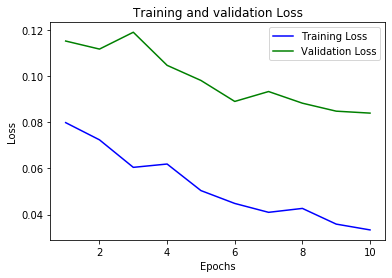

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

#acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [51]:
trfile = open('spam_bert_test_20.csv', "ab")    
np.savetxt(trfile, res, fmt="%2.6f",delimiter=",")
trfile.close()

In [52]:
fpr, tpr, thresholds = roc_curve(test_Y, pred_Y)
auc(fpr, tpr)

0.9399364795863251

In [53]:

print("precision : ", precision_score(test_Y, pred_Y, average="micro"))
print("recall : ", recall_score(test_Y, pred_Y, average="micro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="micro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))
#print(confusion_matrix(test_Y, pred_Y))

precision :  0.9784560143626571
recall :  0.9784560143626571
f1_score :  0.9784560143626571
accuracy_score :  0.9784560143626571


In [54]:
print("precision : ", precision_score(test_Y, pred_Y, average="macro"))
print("recall : ", recall_score(test_Y, pred_Y, average="macro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="macro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))

precision :  0.9621987666931487
recall :  0.9399364795863251
f1_score :  0.9506806862202546
accuracy_score :  0.9784560143626571


In [55]:
model_name="model_spam_bert_classifier.hdf5" 
#checkpointer = ModelCheckpoint(model_name, monitor='loss', save_best_only=True, mode='min')
checkpointer = ModelCheckpoint(model_name, monitor='loss')
history = model.fit(inputs, np.array(train_Y), epochs=30, batch_size=32, 
                    validation_split=0.2, shuffle=True, callbacks=[checkpointer])

Train on 3566 samples, validate on 892 samples
Epoch 1/30
3566/3566 [==============================] - 103s 29ms/sample - loss: 0.0349 - accuracy: 0.9964 - val_loss: 0.0873 - val_accuracy: 0.9854
Epoch 2/30
3566/3566 [==============================] - 105s 29ms/sample - loss: 0.0370 - accuracy: 0.9955 - val_loss: 0.0871 - val_accuracy: 0.9832
Epoch 3/30
3566/3566 [==============================] - 105s 29ms/sample - loss: 0.0310 - accuracy: 0.9975 - val_loss: 0.0841 - val_accuracy: 0.9809
Epoch 4/30
3566/3566 [==============================] - 100s 28ms/sample - loss: 0.0307 - accuracy: 0.9975 - val_loss: 0.0843 - val_accuracy: 0.9854
Epoch 5/30
3566/3566 [==============================] - 100s 28ms/sample - loss: 0.0276 - accuracy: 0.9980 - val_loss: 0.1008 - val_accuracy: 0.9798
Epoch 6/30
3566/3566 [==============================] - 106s 30ms/sample - loss: 0.0289 - accuracy: 0.9969 - val_loss: 0.0838 - val_accuracy: 0.9843
Epoch 7/30
3566/3566 [==============================] - 105

In [56]:
history.history['loss']

[0.034850704632553235,
 0.03696172626765337,
 0.030968039036967147,
 0.030701114043417903,
 0.02762686619164231,
 0.02889442527003323,
 0.029077537142605307,
 0.028306226398058305,
 0.03665485502175247,
 0.026893979721962235,
 0.025183745294775912,
 0.03447365889088598,
 0.033002049503905416,
 0.024277559042277793,
 0.023601206519917296,
 0.020898169320258477,
 0.0236475358357255,
 0.023227335566543023,
 0.024825784738164602,
 0.030219530691959453,
 0.021913901305706796,
 0.020196174560255773,
 0.020428397701619652,
 0.019850250331458253,
 0.022095564491649858,
 0.020336596425298854,
 0.020116057989683234,
 0.020879139006973583,
 0.023163914812109273,
 0.0213424925641713]

In [58]:
trfile = open('spam_bert_train_50.csv', "ab")    
np.savetxt(trfile, history.history['loss'], fmt="%2.6f",delimiter=",")
trfile.close()

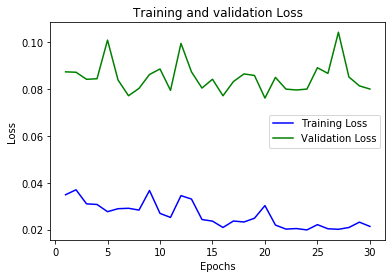

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

#acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
trfile = open('spam_bert_test_50.csv', "ab")    
np.savetxt(trfile, res, fmt="%2.6f",delimiter=",")
trfile.close()

In [67]:
fpr, tpr, thresholds = roc_curve(test_Y, pred_Y)
auc(fpr, tpr)

0.9574189970688426

In [68]:
print("precision : ", precision_score(test_Y, pred_Y, average="micro"))
print("recall : ", recall_score(test_Y, pred_Y, average="micro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="micro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))
#print(confusion_matrix(test_Y, pred_Y))

precision :  0.9829443447037702
recall :  0.9829443447037702
f1_score :  0.9829443447037701
accuracy_score :  0.9829443447037702


In [69]:
print("precision : ", precision_score(test_Y, pred_Y, average="macro"))
print("recall : ", recall_score(test_Y, pred_Y, average="macro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="macro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))

precision :  0.9657817541801115
recall :  0.9574189970688426
f1_score :  0.9615467766402935
accuracy_score :  0.9829443447037702
